# Introduction to Spike Trains

*Code adapted from Chapter 3 of Nylen, E.L., and Wallisch, P.. (2017).* Neural Data Science. *Academic Press. by Aaron J. Newman. Explanatory text by Aaron J. Newman.*

## Overview
This is a lesson that introduces spike trains, how they can be represented as data, and some ways of working with and visualizing them. As well, it introduces a few new bits of Python syntax and a discussion of the use of colour in scientific visualization. 

## Learning Objectives
Once you've completed this lesson you should be able to:
### Spike trains
- define spike trains
- explain how spike train data is recorded
- describe two ways of storing spike train data: time series and spike times
- interpret raster plots and peri-stimulus time histograms
- generate those two types of visualizations

### Python
- explain what a pickle is in Python, and some advantages and disadvantages of pickling
- use subplots to plot multiple levels of data in a single graphic
- understand and properly use Python's naming convention (snake case) for variable names
- properly use whitespace in formatting your code
- consider the relative benefits of hard-coding values in your code, versus writing snippets of code that derive these values from the data itself
- use nested list comprehension
- make informed decisions about the choice of colour map and interpolation method in scientific visualization

---
## Spike Trains

As you know, neurons communicate by generating action potentials. Action potentials are also called "spikes", because when they are recorded, they manifest as spikes in the electrical recording - transient changes from a baseline level of voltage to a different level, then a return to baseline. Neurons have a negative resting potential, meaning that their intracellular space has a negative voltage (more negative ions, like chloride) relative to the extracellular space (which has more positive ions like sodium). When an action potential occurs, ion channels in the neuron's cell wall open, allowing the intracellular space to become more positive. Thus the neuron **depolarizes** when it fires, and its voltage moves closer to zero. The sodium-potassium pumps on the cell wall then re-polarize the neuron to its resting (negative) voltage. 

Spike trains are recordings of action potentials, from electrodes implanted in the brain. Often these are from **intracellular** recordings, meaning that an electrode penetrated the membrane of a neuron and records its action potentials. In other cases, spike train data may be from **extracellular** recordings, in which the electrode is inserted into the brain but does not penetrate a neuron. Instead, the electrode is located in extracellular space (between cells). In this case, the electrode will likely pick up action potentials from multiple nearby neurons. Extracellular recordings are commonly done with arrays of closely-spaced electrodes, such that multiple electrodes pick up the spiking of each neuron but — based on the proximity of the neurons to the electrodes — each electrode likely picks up action potentials from only a subset of the neurons that another electrode does. A process called **spike sorting** is applied to the data after it is recorded to attempt to identify spikes from different neurons, based on which electrodes detect which spikes. 

Spike train data are *binary* — either a neuron is spiking ("on") or not ("off"). This is distinct from many other types of neural data, such as EEG or fMRI, or even local field potentials recorded from implanted electrodes. A neuron is either firing or not, and each spike is very short in duration. 

Therefore, spike data, or "spike trains", ultimately consist of information concerning the times at which spikes occurred. Broadly speaking, there are two forms for this sort of data. In what I'll call the "continuous" form, we have data at every time point over a time period (e.g., a 2 s period covering one trial in an experiment). At each time point, the data is either 0 (no spike) or 1 (spike). In the "discontinuous" form, the data instead are represented as the time points at which spikes occurred. This is a more efficient way of representing the data, since we don't encode all those time points where nothing happened. But regardless, both are valid ways of representing the data that you'll see in this unit of the course. 

Here's [a great article by neuroscientist Mark Humphries](https://medium.com/the-spike/a-neural-data-science-how-and-why-d7e3969086f2) on spike trains in a data science context, that will give you more background information (thanks to student Meg South for the link!). This notebook gets you started on the first of the three approaches he talks about; specifically, determining whether there is structure in the data. 

## A fine pickle we've got ourselves in
Naturally, the first cell in our notebook imports the packages we'll need. Most of the content in the cell below is stuff you've seen before. The one new thing is `import pickle`. Naturally, a programming language named after a snake has a library named after preserved cucumbers! In fact, **pickling** in Python is a way of preserving objects for future use. Recall that Python is an *object-oriented* language, which for purposes of this explanation means that most "things" in Python are objects. This includes ways of storing data such as lists and dictionaries. Pickling is a way of storing objects like this — typically containing data — so that you can later re-load them easily. This can be especially useful if you have complex code or large data sets, where it might take a long time to run the code to get the data into the form that you want (e.g., lots of processing steps, or a computationally-intensive machine learning algorithm).

In many cases, you can and should store data in more standard file formats like text, or CSV. However, such files store data in a basic, tabular structure, whereas Python objects like dictionaries have their own unique structures that serve specific purposes. The end result of a data processing workflow may well be a Python object that doesn't easily lend itself to saving in a text file, in which case pickling can be useful. Also, pickling is formally a type of **serialization** — putting a Python object into a **byte stream** which simply means it's an ordered set of bytes. Serialization allows Python objects to be easily transmitted over internet protocols like TCP/IP, so it can be useful in web applications. 

On the other hand, there are a few downsides to pickles. One is that they are inherently insecure. In general, you should not load pickles that you did not create, if you do not fully know and trust the source. Pickles can be "weaponized" to contain malicious code. Although we are using a pickle obtained from the internet in this exercise, it's from a trusted source: the publisher Elsevier's website. Secondly, because pickles are Python-specific, they are not a very open form of data storage. Pickles are not even strictly compatible between Python versions 2 and 3; below I had to adapt the code to import a Python 2 pickle into Python 3. It's a simple adaptation but nonetheless adds complexity. In general, for sharing data you should use standard file format types.

For more information on pickles, [DataCamp has a good article](https://www.datacamp.com/community/tutorials/pickle-python-tutorial).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Our first spike train

Below we create a list of binary (1 or 0) values. Python lists are ordered, which makes them a good way of storing sequential data like a time series. In the list below, each value represents an evenly-spaced point in time (e.g., one data value every 10 ms), where `0` encodes time points at which no action potential was detected, and `1` represents times when action potentials occurred. 

In [2]:
spikeTrain = [0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0]

<div class="alert alert-block alert-info">
    <h3>Style note:</h3>
    
Nylen and Wallisch use **camel case** in naming their variables. This is a convention in which, if a variable name is multiple words (like "spike train"), the first letter of every word other than the first is capitalized — so below we have `spikeTrain` (actually, this is a sub-type of camel case called **dromedary case**, distinct from **Pascal case** in which the first letter is also capitalized). Camel case is distinct from **snake case**, in which words are separated by underscores (e.g., `spike_train`), which is what you will have seen in virtually all of the Python code used in this course (and on DataCamp). 
    
You will likely encounter both of these naming conventions (and others) in your future coding adventures. However, in Python PEP 8 provides [standard guidelines for naming variables and other objects in Python](https://www.python.org/dev/peps/pep-0008/#naming-conventions) (remember, PEPs are the "Python Enhancement Proposals" that provide standards for the language). PEP 8 specifies that camel case should only be used for naming classes and type variables, and that regular variables "should be lowercase, with words separated by underscores as necessary to improve readability" (i.e., snake case). Don't worry if you don't know what classes and type variables are; the point is that the Python convention is to use lower-case variable names, with words separated by underscores. 
    
There are good reasons for following these conventions — when a seasoned Python programmer sees something in camel case, they will expect it to be a class or type variable, not a regular variable. Following Python's conventions thus improves the readability, sharability, and transparency of code. It's uncclear why Nylen and Wallisch did not use Python's conventions for naming variables — possibly because the naming conventions are different in Matlab, and their book shows all code in both Python and Matlab versions, so naming variables similarly makes it easier to compare the code in the two languages. Regardless, while I have preserved their naming conventions here (to save time and create this teachable moment), you should *not* use camel case for variable names in your own coding. 
</div>

## Stimulus locking

In this hypothetical experiment, the neuron in question was genetically engineered for **optogenetics**, meaning that it expresses genes sensitive to a specific wavelength of light (550 nm, which is green). When light of that wavelength is directed at the neuron, it tends to fire. In this experiment, the light was turned on at time point 5 in the spike train data. 

The code below defines that light onset time as a variable, and also defines that a spike is represented as a 1 in the data. 

In [3]:
lightOnsetTime = 5
spikeValue = 1

A characteristic feature of a neuron is the *first spike latency to stimulus* — how long after a stimulus the first spike occurs. The code below finds this value for our data, and assigns it to a variable.

In [4]:
latencyToFirstSpike = spikeTrain[lightOnsetTime:].index(spikeValue) 
print(latencyToFirstSpike)

4


Here we find the time points of all spikes in the spike train:

In [5]:
spikeTimes = [i for i,x in enumerate(spikeTrain) if x==1]
print(spikeTimes)

[9, 11, 13, 17]


### List comprehension
The above code uses some elegant Python list comprehension:

`spikeTimes = [i for i,x in enumerate(spikeTrain) if x==1]`

Take some time to break this down and understand it — there's a lot going on! Recall that list comprehension is used to create a `for` loop in a single line, and return a list. It's a useful and compact way to iterate over some set of items to get them into a list. The `enumerate` function is a useful one to use in `for` loops, because it enumerates (counts) the items as it goes through a loop. Below you can see what `enumerate` returns in this case: for a given trial (one list of spike trains), for each value in `spikeTrain` we get the value, preceded by its position in the list (0, 1, 2, etc). 

In [6]:
for i,x in enumerate(spikeTrain):
    print(str(i) + ' ' + str(x))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 1
10 0
11 1
12 0
13 1
14 0
15 0
16 0
17 1
18 0
19 0
20 0


The third part of the line of code above adds a conditional: `if x==1`. Thus the code only returns the position in the spike train of the `1`s — the spikes — and not the zeros. 

For a review of list comprehension, check out [this DataCamp tutorial](https://www.datacamp.com/community/tutorials/python-list-comprehension).

## Raster plot

Although this is an extremely small and simple dataset, in real experiments typically we have far more data. Visualization is a highly effective way of making the data more interpretable. Below we generate a **raster plot**, which shows the spikes as vertical lines, with time on the *x* axis. The *y* axis is shown as a continuous scale (the default in matplotlib), but of course the actual values can only be 0 or 1. 

One thing to notice in the code for this plot is that it's kind of "hacking" matplotlib functions to generate the plot. That is, we're not using a standard matplotlib plot class like a bar chart or a histogram. Instead, we use the `matplotlib.pyplot.vlines` function (recall above we imported `matplotlib.pyplot` as `plt`) which will draw a vertical line anywhere on a plot. This is often used for manually drawing a line on top of data. In this case, however, we pass the `spikeTimes` list to `plt.vlines` and use this function to actually plot our data. The code below also uses the `axvspan` function to add green shading to the time period during which the green light was on. Note the clever use of colour-coding; rather than using an arbitrary or neutral shading colour like grey, the colour simultaneously encodes the time of the stimulus, and a key property of it. This is effective communication!

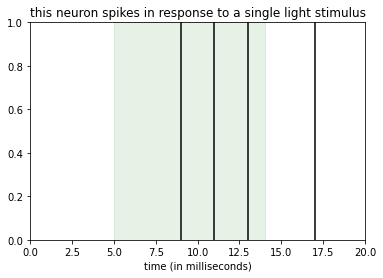

In [7]:
fig = plt.figure()
ax = plt.subplot(111)
plt.vlines(spikeTimes, 0, 1)
plt.ylim([0,1])
plt.axvspan(5,14,alpha=0.1,color='g')
plt.xlim([0,20])
plt.title('this neuron spikes in response to a single light stimulus') 
plt.xlabel('time (in milliseconds)')
plt.show()

## More data

Naturally, in a real experiment we would not stimulate a neuron once, record the data, and say the experiment was finished and that the one spike train was representative of what that neuron would do every time it's stimulated. We would want to run repeated trials to identify the consistent properties of the neuron (and likely record from more neurons as well; we'll come to that in the next notebook)

Below we create 10 spike trains, representing 10 trials. These are stored as a list of lists. 

In [8]:
tenSpikeTrains = [[0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0],
                  [1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,0,0],
                  [0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0]
                 ]

Although the nicely-formatted list of lists above is pretty easy to look at and see where spikes occur, a graph will definitely be a more effective way of communicating this information, because we can add details that aid in interpretation, such as a time axis, shading to indicate when the light is on, axis labels, and a title. 

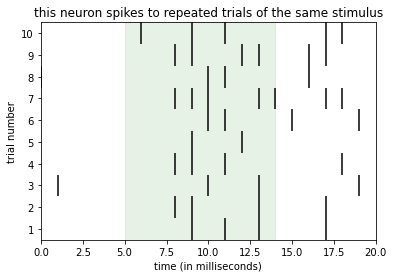

In [9]:
fig = plt.figure()
ax = plt.subplot(1,1,1)
for trial in range(len(tenSpikeTrains)):
    spikeTimes = [i for i,x in enumerate(tenSpikeTrains[trial]) if x==1]
    plt.vlines(spikeTimes,trial,trial+1)
plt.axvspan(5,14,alpha=0.1,color='g')
plt.xlim([0,20])
plt.ylim([0,10])
plt.title('this neuron spikes to repeated trials of the same stimulus')
plt.xlabel('time (in milliseconds)')
plt.ylabel('trial number')
plt.yticks([x+0.5 for x in \
            range(10)],[str(x+1) for x in \
                        range(10)]) #1

plt.show()

Note in the plot command above how each trial is drawn as a separate row in the graph, again using `plt.vlines()`. The API for `plt.vlines()` shows that the first three arguments are: `vlines(x, ymin, ymax)`. In the code above, the trial number (which is a variable `trial`, that's iterated over in the `for` loop) is used as `ymin` and the next trial number (`trial+1`) as `ymax`. This is in contrast to the first raster plot (for one trial), where `ymin` and `ymax` were set to `0` and `1`, respectively, to span the whole *y* axis.

<div class="alert alert-block alert-info">
    <h3>Another style note</h3>

Although I adapted some of the early code in this notebook, I have left the code below as it came. Notably, the authors did not put whitespace between variable names and symbols. For example, where they have:

`fig=plt.figure()`

I would write:

`fig = plt.figure()`

And likewise where they have:

`plt.axvspan(5,14,alpha=0.1,color='limegreen')`

I would write:

`plt.axvspan(5, 14, alpha=0.1, color='limegreen')`

Putting spaces between variable names and symbols like `=`, and after commas, is standard in Python and improves readability. Note however, that for function arguments(with parentheses), we *don't* use spaces around the `=` symbols. This helps save space and makes it easier to parse that what comes after the `=` is part of the same function argument.
</div>

## Spike train and PSTH

ALong with raster plots, another common way of visualizing spike train data is the *peri-stimulus time histogram* (PSTH). As the name implies, this is a histogram — a plot of the count of spikes at each time point in the spike trains. PSTHs are a useful tool in aggregating the data across trials. As biological entities, neurons are complex and do not always spike at exactly the same time, or rate, every time they are stimulated. This is why we collect data over many trials — to identify the average pattern of responding. By summing the number of spikes at each time point, PSTHs allow us to visualize when the neuron is most likely to spike.

The code below uses `plt.subplot` to nicely combine the raster and PSTH in one figure, which allows us to see the data in both representations. This is helpful because we can see the raw data (raster) and the aggregated version (PSTH).

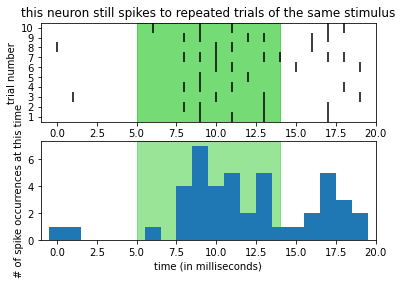

In [10]:
fig=plt.figure()
ax=plt.subplot(211)
for trial in range(len(tenSpikeTrains)): 
    spikeTimes = [i for i,x in enumerate(tenSpikeTrains[trial]) if x==1] 
    plt.vlines(spikeTimes,trial,trial+1) 
    plt.axvspan(5,14,alpha=0.1,color='limegreen') 
    plt.ylim([0,10])
plt.title('this neuron still spikes to repeated trials of the same stimulus')
plt.xlabel('time (in milliseconds)')
plt.ylabel('trial number')
plt.yticks([x+0.5 for x in range(10)], [str(x+1) for x in range(10)])
plt.xlim([-1,20])


ax=plt.subplot(212)
plt.axvspan(5,14,alpha=0.5,color='limegreen')
ax.bar(range(21),np.sum(tenSpikeTrains,0),1)
plt.xlabel('time (in milliseconds)')
plt.ylabel('# of spike occurrences at this time')
plt.xlim([-1,20])
plt.show()

The above PSTH simply plots the number of spikes per time bin (using the `np.sum()` function). Thus the numbers plotted are somewhat arbitrary, in that they will differ depending on the number of trials that were run. As well, even when we see peaks in the histogram, if we visualize the raw count without knowing the number of trials that contributed, we don't have a good way of interpreting the data. That is, since we know here that we have 10 trials, a count of 7 is a high proportion of trials. However, if the data comprised 25 trials, a peak of 7 would likely not be compelling evidence that the neuron was responsive to the stimulus. We should always strive for transparency and readability in visualizing data, and minimize the need for the viewer to read additional material (e.g., the methods section where hopefully the number of trials is reported) to interpret the plot. As well, plotting things in standardized units makes it easier to compare across plots, articles, etc.. 

In the case of PSTHs, what we really want to know is how *probable* is it that the neuron will fire at a particular time point after a stimulus, across trials. We can do this by simply computing the mean number of spikes at each time point. Since the only possible values are 0 or 1, the mean will represent the proportion of times that the neuron spiked at that time point, regardless of how many trials comprised the data.

We might also want to get a sense, visually, of whether the probability of firing is greater than chance, and thus related to the stimulus. Since the neuron only has two possible states (firing or not), a simple criterion would be to say that if the neuron fires on more than 50% of trials, it is responding to the stimulus. We can facilitate this interpretation for our viewer by adding a horizontal dashed line at 0.5 on the *y* axis, using `plt.axhline()`:

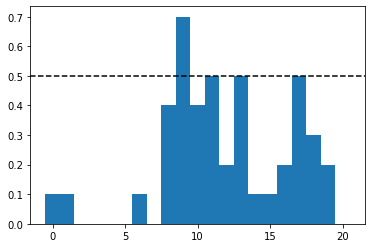

In [11]:
fig=plt.figure()
plt.bar(range(21), np.mean(tenSpikeTrains,0),1)
plt.axhline(y=0.5,xmin=0,xmax=20,linestyle='--',color='k')
plt.show()

We can add further details to the plot to enhance interpretation even more:

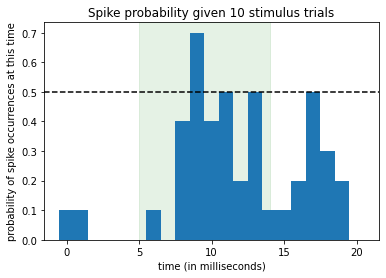

In [12]:
fig=plt.figure() 
plt.axvspan(5,14,alpha=0.1,color='g') 
plt.bar(range(21), np.mean(tenSpikeTrains,0),1) 
plt.axhline(y=0.5,xmin=0,xmax=20,linestyle='--',color='k')
plt.title('Spike probability given 10 stimulus trials')
plt.xlabel('time (in milliseconds)')
plt.ylabel('probability of spike occurrences at this time')
plt.savefig('Figure 3.8normalized PSTH with cutoff.png')
plt.show()

## Ten intensities — A bigger data set

Here's where we use pickled data. The code below loads it.

In [13]:
with open('tenIntensities.pkl', 'rb') as handle:
    tenIntensities = pickle.load(handle, encoding='latin1')

Although we have the code below to work with the data, it's worth taking a moment to look at the data and understand how it's represented. Firstly, what Python type is it?

In [14]:
type(tenIntensities)

dict

How big is it?

In [15]:
len(tenIntensities)

10

How is the dictionary keyed? This may tell us something about the data, if the keys are informative labels:

In [16]:
tenIntensities.keys()

dict_keys(['4_intensity', '2_intensity', '8_intensity', '0_intensity', '7_intensity', '5_intensity', '9_intensity', '6_intensity', '3_intensity', '1_intensity'])

So the keys indicate that these are different intensity values, spanning a range from 0–9. Let's look at what the values are for one of those keys:

In [17]:
tenIntensities['0_intensity']

[[83.0, 41.0],
 [14.0, 87.0, 18.0, 84.0],
 [24.0, 51.0, 66.0, 86.0, 96.0],
 [26.0, 14.0, 51.0, 20.0, 50.0, 23.0],
 [14.0, 27.0, 60.0, 45.0, 56.0, 58.0, 60.0],
 [48.0, 18.0, 40.0, 43.0],
 [13.0, 46.0, 47.0, 90.0],
 [33.0, 61.0, 55.0, 64.0, 56.0],
 [72.0, 64.0, 45.0, 82.0],
 [34.0, 74.0, 71.0, 53.0]]

OK, so it looks like for each intensity we have a list of lists, and each of those lists is a different length, and contains a range of values. We could hypothesize that those values range from 0–100, although we'd want to interrogate the data more to confirm that. Regardless, one intriguing thing is that these are not spike trains like we saw before, which were all of the same length (since each entry in the list represented a specific point in time) and which had values of only 0 or 1.

Let's look at another entry in the dictionary to get more of a sense of how the data for different intensities look:

In [18]:
tenIntensities['1_intensity']

[[61.0, 17.0, 36.0, 74.0],
 [13.0, 64.0, 30.0, 47.0],
 [20.0, 27.0, 56.0, 27.0, 68.0, 73.0, 59.0],
 [68.0, 46.0, 48.0, 25.0],
 [68.0, 34.0, 48.0, 22.0],
 [51.0, 66.0, 45.0, 49.0, 66.0, 40.0],
 [13.0, 51.0, 18.0, 58.0, 58.0],
 [23.0, 36.0, 71.0, 73.0],
 [24.0, 33.0, 32.0, 43.0, 15.0, 53.0, 70.0],
 [53.0, 35.0, 43.0, 23.0]]

It looks like there are the same number of lists in each dictionary entry, but we can confirm that with a simple loop through all the keys in the dictionary:

In [19]:
for intensity_lev in tenIntensities.keys():
    print(intensity_lev + ' ' + str(len(tenIntensities.values())))

4_intensity 10
2_intensity 10
8_intensity 10
0_intensity 10
7_intensity 10
5_intensity 10
9_intensity 10
6_intensity 10
3_intensity 10
1_intensity 10


So it looks like we have 10 levels of intensity (intensity of what, we don't know), and 10 trials for each intensity level. However, within each trial the values aren't spike trains of zeros or ones, but instead values that appear to range between 0 and 100. This is rather puzzling! This would be a hard data set to decode without some additional information from whoever provided the data, to tell us what it's encoding. Fortunately Nylen and Wallisch are here to help. They tell us that this was another optogenetics experiment, this time with the intensity (brightness) of the light being systematically varied. The values in each list are spike times — in other words, the times at which spikes occur. As noted earlier, this is an alternative and more concise/efficient way of representing spike data; rather than needing to store data for every time point, we only store data for the time points at which spikes occur.

The data are still a bit confusing, though. Firstly, the values in these lists the spike times are not always sequential. For example, in the first list within `0_intensity`, the values are `[83.0, 41.0]`. Logically, we would expect the spike times to be temporally ordered. Moreover, in some cases a list has two identical values, for example:

In [20]:
tenIntensities['1_intensity'][5]

[51.0, 66.0, 45.0, 49.0, 66.0, 40.0]

It's unclear why the data are like this, and Nylen and Wallisch provide no insights in their book. Since this is only an example, and the plots below work and serve to demonstrate how to visualize this data, we won't worry about it too much. My suspicion is that they used a random number generator to generate simulated data. But exploring your data, and asking questions like this, is an important part of data science, and science more generally. If you identify strange or unexpected things in the data, it's worth investigating further and trying to understand *why*, rather than just assuming that whoever provided the data didn't make any mistakes. 

## Visualizing data across intensity levels

Our questions about the data notwithstanding, we know that we have spike train data from multiple trials, and the code below plots the data as rasters and PSTHs, as a function of intensity:

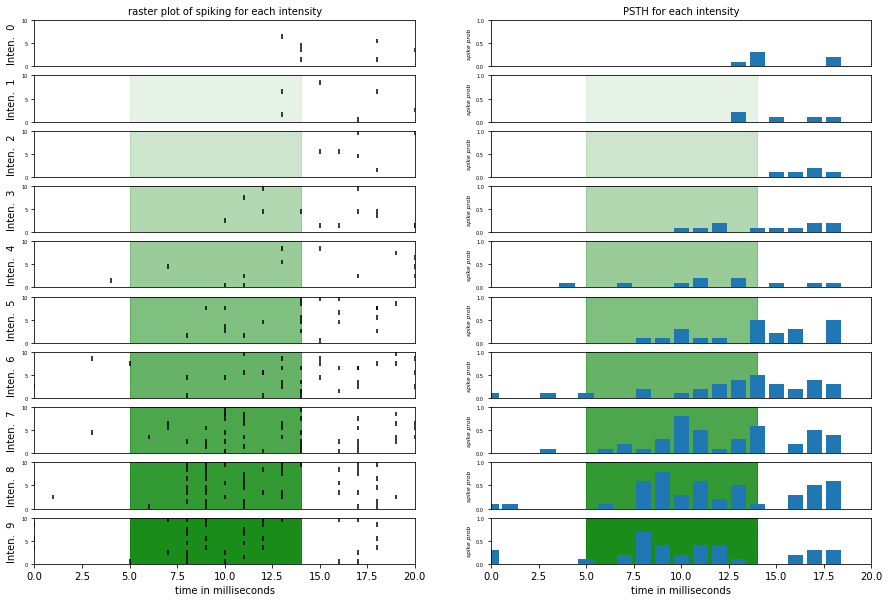

In [21]:
fig = plt.figure(figsize=[15,10])
numIntensities = len(tenIntensities)
nbar={}
for key in tenIntensities.keys():
    # Raster plots
    # The line below sets the subplot in which to graph the data from a particular 
    # intensity level. Although dictionaries are not ordered, the resulting plot has the 
    # intensities ordered from lowest to highest. This works because the dictionary keys
    # in this case are the intensity levels, as numerals. So when we select the first 
    # character in the key (key[0]) and convert it to float, Python will select the 
    # approriate row of the figure to plot the data in. 
    # Another thing to note is that the rows are selected by mutiplying the intensity 
    # levels by two, then adding one. The +1 is because, in an exception to what is typical 
    # in Python, figure subplots are numbered from 1 rather than zero. So intensity 
    # level 0 goes in row 1 of the plot. Mutiplying by 2 is because we have two columns 
    # in the plot, and the subplots are numbered sequentially (i.e., subplot 2 is first 
    # row, second column, subplot 3 is first column second row, etc.)
    ax=plt.subplot(numIntensities,2,float(key[0])*2+1)
 
    for trial in range(10): 
        plt.vlines(tenIntensities[key][trial],trial,trial+1)
    plt.xlim([0,20])
    plt.ylim([0,10])
    plt.ylabel('Inten.  ' + str(key[0]),fontsize=10)
    plt.yticks(fontsize=5)
    
    # The line below sets the intensity of the green shading (indicating when the stimulus
    # was on) according to the intensity of the stimulus. This is done using the alpha 
    # argument to plt.axvspan. Alpha sets the transparency of a visual element, over a 
    # range from 0 (transparent) to 1 (opaque). So by multiplying by 0.1 we turn the 
    # intensity values (which range from 0 to 9) into acceptable alpha values.
    plt.axvspan(5,14,alpha=0.1*float(key[0]),color='g')
    
    # Place x ticks and x label only below bottom row of plots:    
    if float(key[0]) < 9:
        plt.xlabel('')
        plt.xticks([])
    else:
        plt.xlabel('time in milliseconds')
        
    # Add title only above top row (intensity 0):
    if float(key[0]) == 0:
        plt.title('raster plot of spiking for each intensity',fontsize=10)
        
    # PSTHs    
    ax=plt.subplot(numIntensities,2,float(key[0])*2+2)
    plt.axvspan(5,14,alpha=0.1*float(key[0]),color='g')
    
    # Next line is an interesting list comprehension that takes the list of lists, 
    # and outputs one long list of all the values (since for a histogram we don't 
    # care which trial the data came from, we want to collapse over the trials)
    spikeTimes = [a for b in tenIntensities[key] for a in b] 
    
    # Make a histogram of the values. The range(20) argument ignores any data 
    # from time points past 20 s. Don't draw the histogram but return it as two variables. 
    # According to its API, np.histogram returns the values of the histogram as an array, 
    # and the bin edges
    nOut,bins=np.histogram(spikeTimes,bins=range(20))
    
    # Compute probability for the histogram by dividing by number of trials
    nbar[float(key[0])] = nOut/10.
    plt.bar(bins[:-1],nOut/10.)
    plt.xlim([0,20])
    plt.ylim([0,1])
    plt.yticks(fontsize=5)
    plt.ylabel('spike prob',style='italic',fontsize = 6)

    # place title only above the first row of plots:
    if float(key[0]) == 0:
        plt.title('PSTH for each intensity',fontsize=10)
        
    # Place x ticks and x label only below bottom row of plots:    
    if float(key[0]) < numIntensities-1:
        plt.xlabel('')
        plt.xticks([])
    else:
        plt.xlabel('time in milliseconds')
        
plt.show()

There is a lot going on in that plotting code! I've annotated some of it using comments, but there is more to unpack, that helps us infer more things about the data and answer some of the questions I raised above. 

Before we get there, I'll note that there is a lot of "hard coding" of values in this code. For example, the line `for trial in range(10):`  only works because we know that there are precisely 10 trials at every intensity level, that we want to loop through. This is fine for this data set, but it's not very robust code; if we tried to use it with data that had a different number of trials, or a variable number of trials per intensity level, this code would break. A more robust way of doing this would be to use the `len()` function, as in `len(tenIntensities[key])`, so the line would become:

    for trial in range(len(tenIntensities[key])):

The lines right below this one, which set the plot's axis limits, are similarly hard-coded based on the authors' knowledge of the data:

    plt.xlim([0,20])
    plt.ylim([0,10])
    
The second line sets the *y* axis limits for the raster plots to 10, because that's how many trials there are. Again, this will not work if the number of trials is different, or variable, and we could again use `len(tenIntensities[key])` here. In fact, we could go a step further, and make the number of trials a variable. In general, if you find that you're using the same function(s) repeatedly in a chunk of code like this, you'll find it easier, and create more readable and cleaner code, if you assign it to a variable, for example:

    num_trials = len(tenIntensities[key]) 
    
Since we're anticipating the possibility that different intensity levels have different numbers of trials, we would want to (re)set this variable for each intensity level as we loop through them. So instead of this code from the loop above:

    for key in tenIntensities.keys():
        ax=plt.subplot(numIntensities,2,float(key[0])*2+1)
        for trial in range(10): 

We would use:

    for key in tenIntensities.keys():
        num_trials = len(tenIntensities[key])
        ax=plt.subplot(numIntensities,2,float(key[0])*2+1)
        for trial in range(num_trials):

and then later:

    plt.ylim([0,num_trials])

The line `plt.xlim([0,20])` is more interesting. This sets the *x* axis limits to range from 0 to 20, and the label that is assigned to the *x* axis tells us that this is time, measured in seconds. So we're seeing the rasters for times between the start of the trial, up to 20 s. However, as noted earlier when we were first exploring the tenIntensities data set, the values in the data range from 0 to almost 100. We can see in the code above that the raster plots are generated by the line:

    plt.vlines(tenIntensities[key][trial],trial,trial+1)
    
So, the code is using the values in `tenIntensities` (for that particular intensity (key) and trial to determine the positions of the lines in the raster plots. In other words, those numbers in `tenIntensities` are, indeed, the times of spikes. What the authors have done here is explicitly limited the time window for the plots to 0-20 s, and any spike times >20 are simply ignored because they're outside the *x* axis range specified by the code. In fact, if we change the two occurrences of `plt.xlim([0,20])` in that code to set a range up to 100 s, we see something interesting:

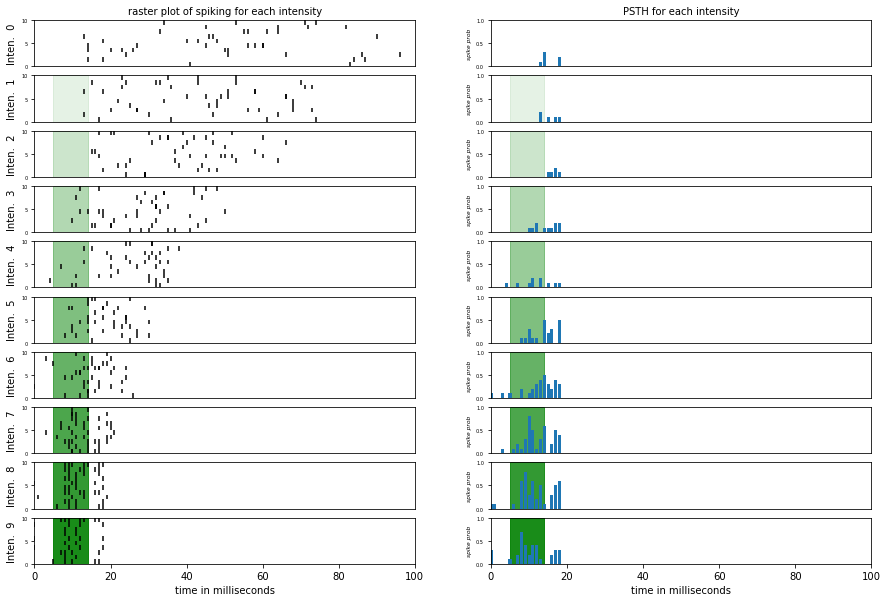

In [22]:
fig = plt.figure(figsize=[15,10])
numIntensities = len(tenIntensities)
nbar={}
for key in tenIntensities.keys():
    # Raster plots
    ax=plt.subplot(numIntensities,2,float(key[0])*2+1) 
    for trial in range(10): 
        plt.vlines(tenIntensities[key][trial],trial,trial+1)
    plt.xlim([0,100])
    plt.ylim([0,10])
    plt.ylabel('Inten.  ' + str(key[0]),fontsize=10)
    plt.yticks(fontsize=5)    
    plt.axvspan(5,14,alpha=0.1*float(key[0]),color='g')
    if float(key[0]) < 9:
        plt.xlabel('')
        plt.xticks([])
    else:
        plt.xlabel('time in milliseconds')
    if float(key[0]) == 0:
        plt.title('raster plot of spiking for each intensity',fontsize=10)
        
    # PSTHs    
    ax=plt.subplot(numIntensities,2,float(key[0])*2+2)
    plt.axvspan(5,14,alpha=0.1*float(key[0]),color='g')    
    spikeTimes = [a for b in tenIntensities[key] for a in b]     
    nOut,bins=np.histogram(spikeTimes,bins=range(20))    
    nbar[float(key[0])] = nOut/10.
    plt.bar(bins[:-1],nOut/10.)
    plt.xlim([0,100])
    plt.ylim([0,1])
    plt.yticks(fontsize=5)
    plt.ylabel('spike prob',style='italic',fontsize = 6)
    if float(key[0]) == 0:
        plt.title('PSTH for each intensity',fontsize=10)
    if float(key[0]) < numIntensities-1:
        plt.xlabel('')
        plt.xticks([])
    else:
        plt.xlabel('time in milliseconds')
        
plt.show()

This is definitely weird - it looks like the spikes are spread out differently over time, at different intensity levels. What I suspect is that the authors used a couple of tricks to generate this data - it's not real spike data. As I noted earlier, it looks like the data may have been generated by a random number generator, since they aren't ordered in time, and there's at least one instance of the same value occurring twice in the same trial, which doesn't make sense - how could an electrode record two action potentials from one neuron at the same time? The plot above suggests that the authors generated random values across a range from 1-100 for each intensity level, but then applied a second function that increasingly compressed the time as intensity level increased. They then set a cutoff of 20 s to hide the extraneous data. This resulted in a data set that, over the range of time they planned to plot, there were increasing numbers of spikes, making it appear as if the "neuron" was indeed sensitive to light intensity. 

To be clear, this is not a criticism of the authors; it's really quite an ingenious way to generate data that displays what they wanted. All I'm doing is trying to demonstrate how you can explore data that you're given, essentially "hack" it, and try to understand it better. By being able to understand what every line of code does, break it down, and manipulate it, you can learn a lot! Had I done this, I probably would have removed all of the values in the lists >20 to avoid confusion, but on the other hand by leaving it in, the authors provided this opportunity for exploration and explanation!

Anyway, in this case hard-coding the *x* axis limits makes perfect sense, because we don't want to be flexible or data-driven; rather we want to explicitly limit the plot to a specific and fixed range of values.

### Nested list comprehension

Finally, this line is interesting:

    [a for b in tenIntensities[key] for a in b] 

This is **nested list comprehension**, which applies list comprehension to lists of lists. As noted earlier, each entry in the `tenIntensities` dictionary is a list containing 10 lists, one for each trial:

In [23]:
tenIntensities['0_intensity']

[[83.0, 41.0],
 [14.0, 87.0, 18.0, 84.0],
 [24.0, 51.0, 66.0, 86.0, 96.0],
 [26.0, 14.0, 51.0, 20.0, 50.0, 23.0],
 [14.0, 27.0, 60.0, 45.0, 56.0, 58.0, 60.0],
 [48.0, 18.0, 40.0, 43.0],
 [13.0, 46.0, 47.0, 90.0],
 [33.0, 61.0, 55.0, 64.0, 56.0],
 [72.0, 64.0, 45.0, 82.0],
 [34.0, 74.0, 71.0, 53.0]]

In its simplest form, as used here, nested list comprehension is a way to convert a list of lists to one long list.

The syntax probably looks confusing, to say the least! But it's relatively simple once you learn to read it. In the code

    [a for b in tenIntensities[key] for a in b] 

`b` stands for each item (list) in the list of lists, and `a` stands for the individual items within `b`. For example, in `tenIntensities['0_intensity']` as shown above, for the first item `b` would be `[83.0, 41.0]` and `a` would be `83.0` and `41.0`. So we could read this as "Return `a` (values) for `b` (lists) in tenIntensities[key] (list of lists) for all items (`a`) in each list (`b`)". Since there are square brackets around the entire expression, the result is a list of all these values.

As we see below, if we run this nested list comprehension on the `0_intensity` dictionary values, we get one long list with all the values from the list of lists above, sequentially:

In [24]:
[a for b in tenIntensities['0_intensity'] for a in b] 

[83.0,
 41.0,
 14.0,
 87.0,
 18.0,
 84.0,
 24.0,
 51.0,
 66.0,
 86.0,
 96.0,
 26.0,
 14.0,
 51.0,
 20.0,
 50.0,
 23.0,
 14.0,
 27.0,
 60.0,
 45.0,
 56.0,
 58.0,
 60.0,
 48.0,
 18.0,
 40.0,
 43.0,
 13.0,
 46.0,
 47.0,
 90.0,
 33.0,
 61.0,
 55.0,
 64.0,
 56.0,
 72.0,
 64.0,
 45.0,
 82.0,
 34.0,
 74.0,
 71.0,
 53.0]

For a nice tutorial on list comprehension, culminating in nested list comprehension, check out [this DataCamp article](https://www.datacamp.com/community/tutorials/python-list-comprehension).

## Heat Maps

These are not explicitly explained in the book, but in a sense they are just a prettier version of the PTSH above. However, they are a more condensed version of the PSTHs, because rather than needing 10 plots to show the histograms for all levels of intensity, we can do so in a single plot. Heat maps essentially allow us to plot 3 dimensions rather than only two; we have the *x* and *y* axes, but then we can plot a third variable (dimension) using colour (or intensity of colour). Think of it the above plot rotated in a plane, so that if before, you were looking at the plot from the side, now you're looking at it from above. More intense colours indicate a higher spike probability at that time point. 

For better or for worse, a consequence of the heat map representation is that it takes data that were measured at discrete levels of stimulus intensity, and interpolates between those levels to provide a smoothed representation of the data. In other words, it's filling in what the values would be in between the tested levels of stimulus intensity. 

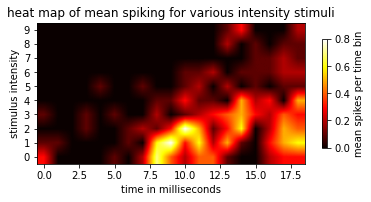

In [25]:
fig = plt.figure()
ax = plt.subplot(111)
# AJN had to adapt to get dict keys to sort
aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],
               cmap='hot', interpolation='bilinear')
plt.yticks([x for x in range(10)],[str(x) for x in range(10)[::-1]])
plt.ylabel('stimulus intensity')
plt.xlabel('time in milliseconds')
plt.title('heat map of mean spiking for various intensity stimuli')
cb = fig.colorbar(aa,shrink=0.5) 
cb.ax.set_ylabel('mean spikes per time bin') # End Python way for Figure 3.10
plt.show()

Below are examples showing different colourmaps and interpolation methods. Blinear and bicubic are smoothed forms of interpolation, where nearest-neighbour looks "blocky" because it's plotting the actual values with no interpolation, more consistent with the actual data. 

This is not to imply that interpolation is invalid; indeed it's a valuable tool. But it's important to be aware of interpolation and consider what effects it might have in some situations. On the one hand, interpolation can make predictions and also reduce noise in the data. On the other hand, if there are big gaps in your data it may note be appropriate to interpolate, because interpolation makes certain assumptions about the shape (distribution) of your data. 

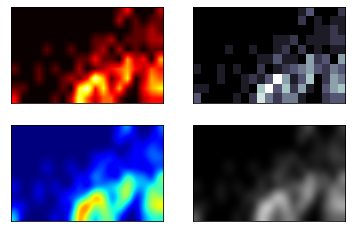

In [26]:
fig = plt.figure()

ax = plt.subplot(221)
aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],
               cmap='hot',interpolation='bilinear',aspect=1.2) 
plt.yticks([]); plt.xticks([])

ax = plt.subplot(222)
aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],
               cmap='bone', interpolation='nearest',aspect=1.2) 
plt.yticks([]); plt.xticks([])

ax = plt.subplot(223);
aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],
               cmap='jet', interpolation='bicubic',aspect=1.2) 
plt.yticks([]); plt.xticks([])

ax = plt.subplot(224)
aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],
               cmap='gray', interpolation='bicubic',aspect=1.2)
plt.yticks([]); plt.xticks([])

plt.show()

### Colourmap choices

One final comment about the heat maps above: your choice of colour map (`cmap`) matters. One way to choose a colour map is based on one's individual intuitions about aesthetics. For example, I personally think the top left one (`cmap='hot'`) is the nicest. However, it's important to consider the neuroscience of how humans interpret colour. Even though the colour spectrum is continuous (wavelengths of electromagnetic radiation ranging from approximately 400–700 nm), we see it as distinct colours (classically, red, orange, yellow, green, blue, indigo violet). Although we can discriminate different hues within each of those colours, we nonetheless see colours categorically. In other words, two equally-different values at different parts of the colour range may not be perceived as the same magnitude of difference. For example in the bottom left (`cmap='jet'`) the green areas seem to 'pop' relative to the blue, and there is a patch of orange that really stands out. Likewise in the top left (hot) map, the is a distinctive patch of bright yellow. However, when we look at the bottom right (greyscale) plot, we see that the values are actually continuous; the same areas are still the most intense, but our brains more naturally see the continuous nature of the data. This is a truer representation of the data, than a colour map that leads to the perception of distinct patches in what is actually continuous data.

Another issue with some colour maps are that they are not always **isoluminent**, meaning that the luminence (brightness) of some colours may be greater than others, again making some differences appear larger than others.

A final issue is that a non-negligible proportion of the population has some form of colourblindness. This can range from mild forms (common) to complete achromatopsia (rare). In fact, it is estimated that 8% of males (1 in 12) have some form of colourblindness; colourblindness is caused by a recessive gene on the X chromosome, so it is far less common for females to have it. So if you anticipate that, say, even 50 people view a graph you make, the odds are that 2 or more of them will have some form of colourblindness. By the way, there is a great app that simulates different forms of colourblindness on your computer, called [Color Oracle](https://colororacle.org) — it's worth checking out! 

In other words, choosing the wrong colour map can mislead viewers in interpreting the data, and may also result in your plots being uninterpretable by some viewers. You should pick a colour map that is **perceptually uniform** (e.g., nearby values have similar-appearing colours across the range), and robust to colourblindness. An excellent choice is one of the [viridis](https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html) family of colourmaps, which were explicitly designed to have these properties, and also be aesthetically appealing. The viridis family is used below:

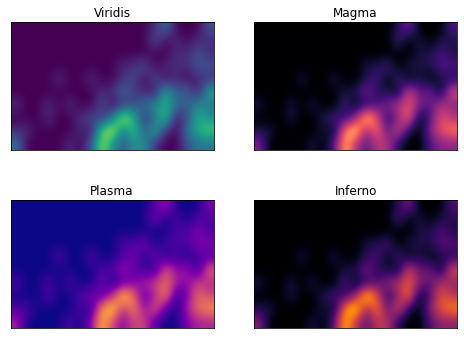

In [27]:
fig = plt.figure(figsize=[8,6])

ax = plt.subplot(221)
aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],
               cmap='viridis',interpolation='bicubic',aspect=1.2) 
ax.set_title("Viridis")
plt.yticks([]); plt.xticks([])

ax = plt.subplot(222)
aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],
               cmap='magma', interpolation='bicubic',aspect=1.2) 
ax.set_title("Magma")
plt.yticks([]); plt.xticks([])

ax = plt.subplot(223);
aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],
               cmap='plasma', interpolation='bicubic',aspect=1.2) 
ax.set_title("Plasma")
plt.yticks([]); plt.xticks([])

ax = plt.subplot(224)
aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],
               cmap='inferno', interpolation='bicubic',aspect=1.2)
ax.set_title("Inferno")
plt.yticks([]); plt.xticks([])

plt.show()

Compare these plots to the ones above that used non-viridis colourmaps (re-generated below, but with the code condensed to save space) and ask yourself how your perception and interpretation of the plots changes between them. 

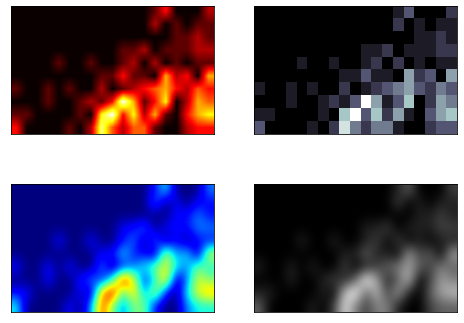

In [28]:
fig = plt.figure(figsize=[8,6])
ax = plt.subplot(221);aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],cmap='hot',interpolation='bilinear',aspect=1.2) ; plt.yticks([]); plt.xticks([])
ax = plt.subplot(222);aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],cmap='bone', interpolation='nearest',aspect=1.2) ;plt.yticks([]); plt.xticks([])
ax = plt.subplot(223);aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],cmap='jet', interpolation='bicubic',aspect=1.2) ;plt.yticks([]); plt.xticks([])
ax = plt.subplot(224);aa = ax.imshow([nbar[i] for i in sorted(nbar.keys())],cmap='gray', interpolation='bicubic',aspect=1.2);plt.yticks([]); plt.xticks([])
plt.show()